This is a tutorial on how to use the FMM RCWA code.

In [3]:
import RCWA_3D_python.base as base
import RCWA_3D_python.materials as mat
import RCWA_3D_python.bunch as bunch
import numpy as np

# Simple imports

Let's define the structure's parameters, as well as some computation variables:
- $M_m$ and $N_m$ re number of modes in x and y direcitons respectively. These numbers can be quite low (~10) for simple (~2-4 interfaces) problems.
- $\eta$ is the stretching parameter

Here we will study the response of an array of a simple Metal-Insulator-Metal (MIM) resonator :

<img src="MIM.png" alt="MIM" width="500"/>

The necessary parameters are:
- height and width of the upper metallic part (the "cube")
- height of the spacer
- period in both directions (typically the same)
- permittivity of the spacer (taken as a constant) and of the metal (varies with the wavelength, so defined later)

And some extra geometrical parameters:
- wavelength $\lambda$
- incidence angle (colatitude) $\theta$
- precession angle $\phi$, with $\phi = 0$ for k in the (x,z) plane
- polarisation (as a rotation around the wavevector, with pol=90 when the E field is parallel to the (x,y) plane (TE))

In [4]:
# Computation parameters: nb of modes and stretching coefficient
Mm = 8
Nm = 8
eta = 0.999

# Structure parameters: size of a MIM resonator
hcube = 40.0               # height of the cube
hspacer = 280.0            # height of the spacer
l_cubex = 2000.0           # cube width along axis x
l_cubey = 2000.0           # cube width along axis y
space_x = 5001-l_cubex     # period along x (RCWA nerd advice, never use an exactly round period)
space_y = 5002-l_cubey     # period along x (RCWA nerd advice, never use an exactly round period)

eps_dielec = 2.2**2        # spacer permittivity
metal_perm = mat.epsAubb   # metal permittivity

# Incidence parameters
lambdas = np.linspace(7000, 13000, 10)
theta = 20.0 * np.pi/180.
phi = 0.0 * np.pi/180.
pol = 90*np.pi/180.

# Results
r = np.zeros(len(lambdas), dtype=complex)

Now let's define the structure itself. Each layer is defined by its interfaces in x and y, the permittivities and permeabilities of each zone.

More precisely, for each layer, we define:
- ox and oy, the interfaces along axis x and y (including the beginning and end of the period) (see image)
- nx and ny, typically the same as ox and oy (they are used if your coordinate stretching modifies the positions (ox = old x, nx = new x))
- Mm, Nm, eta and pol as above
- mu, the permeability in each zone defined by the interfaces
- eps, the permittivity in each zone defined by the interfaces
- pmlx and pmly, 1 if the zones are supposed to be Perfectly Matched Layers. These work by axis, not by zone (see image)

<img src="zones.png" alt="zones" width="500"/>

In [5]:

top = bunch.Bunch() # The top layer (air)
top.ox = [0,l_cubex,l_cubex+space_x]
top.nx = [0,l_cubex,l_cubex+space_x]
top.oy = [0,l_cubey,l_cubey+space_y]
top.ny = [0,l_cubey,l_cubey+space_y]
top.Mm=Mm
top.Nm=Nm
top.mu =  np.array([[1.,1],
                  [1.,1.]])
top.eps =  np.array([[1.,1],
                  [1.,1.]])

top.eta=eta
top.pmlx=[0, 0]
top.pmly=[0, 0]
top.pol = 0.0

bot = bunch.Bunch() # The substrate layer (gold)
bot.ox = [0,l_cubex,l_cubex+space_x]
bot.nx = [0,l_cubex,l_cubex+space_x]
bot.oy = [0,l_cubey,l_cubey+space_y]
bot.ny = [0,l_cubey,l_cubey+space_y]
bot.Mm=Mm
bot.Nm=Nm
bot.mu = np.array([[1.,1],
                  [1.,1.]])
bot.eta=eta
bot.pmlx=[0, 0]
bot.pmly=[0, 0]


spa = bunch.Bunch() # The spacer layer (dielectric)
spa.ox = [0,l_cubex,l_cubex+space_x]
spa.nx = [0,l_cubex,l_cubex+space_x]
spa.oy = [0,l_cubey,l_cubey+space_y]
spa.ny = [0,l_cubey,l_cubey+space_y]
spa.Mm=Mm
spa.Nm=Nm
spa.mu =  np.array([[1.,1],
                  [1.,1.]])
spa.eps =  np.array([[eps_dielec,eps_dielec],
                  [eps_dielec,eps_dielec]])
spa.eta=eta
spa.pmlx=[0, 0]
spa.pmly=[0, 0]

gp = bunch.Bunch() # The cube layer, structured
gp.ox = [0,l_cubex,l_cubex+space_x]
gp.nx = [0,l_cubex,l_cubex+space_x]
gp.oy = [0,l_cubey,l_cubey+space_y]
gp.ny = [0,l_cubey,l_cubey+space_y]
gp.Mm = Mm
gp.Nm = Nm
gp.mu = np.array([[1.,1],
                  [1.,1.]])
gp.eta = eta
gp.pmlx=[0, 0]
gp.pmly=[0, 0]

Since we loop on lambdas, the permittivities for layers that are wavelength dependent are defined later, as well as all parameters that are related to k:
- k0 the wavevector in vacuum
- kx the projection along axis x
- ky the projection along axis y

And then the main computation is done!

In [6]:

for i, lambd in enumerate(lambdas):
    print(lambd)
    e_au = metal_perm(lambd)
    k0 = 2*np.pi/lambd
    top.k0 = k0
    spa.k0 = k0
    bot.k0 = k0
    gp.k0 = k0
    a = -k0 * np.sin(theta) * np.cos(phi)
    top.kx = a
    bot.kx = a
    spa.kx = a
    gp.kx = a
    b = -k0 * np.sin(theta) * np.sin(phi)
    top.ky = b
    bot.ky = b
    spa.ky = b
    gp.ky = b

    bot.eps =  np.array([[e_au,e_au],
                         [e_au,e_au]])
    gp.eps = np.array([[e_au,1.],
                       [1.,1.]])

    
    [Pair,Vair], ext = base.homogene(top, ext=1)
    Vair_sort = Vair#[isort]
    Vair_sort = np.real(Vair_sort) * (np.abs(np.real(Vair_sort))>1e-10) + 1.0j*(np.imag(Vair_sort) * (np.abs(np.imag(Vair_sort))>1e-10))

    [Pgp,Vgp] = base.reseau(gp)
    [Pspa,Vspa] = base.homogene(spa)
    [Psub,Vsub] = base.homogene(bot)
    

    S = base.c_bas(base.interface(Pair, Pgp), Vgp, hcube)
    S = base.cascade(S, base.c_bas(base.interface(Pgp, Pspa), Vspa, hspacer))
    S = base.cascade(S, base.c_bas(base.interface(Pspa, Psub), Vsub, 0))

    # Creating the entry vector
    pol = 0# pi/2
    Ex = np.cos(pol) * np.cos(theta) * np.cos(phi) - np.sin(pol) * np.sin(phi) # Ex incident
    Ey = np.cos(pol) * np.cos(theta) * np.sin(phi) + np.sin(pol) * np.cos(phi) # Ey incident
    eps_k2 = top.eps[0,0] * top.mu[0,0] * top.k0**2 # eps k^2
    d = np.sqrt(eps_k2 - top.kx**2 - top.ky**2) # norm k
    # e = normalisation E
    norm = ((eps_k2-top.ky**2)*np.abs(Ex)**2 + (eps_k2-top.kx**2)*np.abs(Ey)**2 + 2*top.kx*top.ky*np.real(Ex*Ey)) / (top.mu[0,0]*d)
    
    V_inc = np.zeros(4 * (2*Nm+1) *(2*Mm+1))
    V_inc[int(np.real(ext[3,0]))] = Ex/np.sqrt(norm)
    V_inc[int(np.real(ext[3,int(np.real(ext[0,0]))]))] = Ey/np.sqrt(norm)

    V_out = S @ V_inc # outgoing fields
    V_r = V_out[:2 * (2*Nm+1) *(2*Mm+1)]
    reflechi = base.efficace(top, ext, V_r)
    r[i] = reflechi[3,0]

    # We have no transmission in this case but this is how we would do it: 
    # V_t = V_out[2 * (2*Nm+1) *(2*Mm+1):]
    # transm = base.efficace(top, ext, V_t)
    # t[i] = transm[3,0]



7000.0


/home/denis/Documents/Progs/Code_RCWA/RCWA_3D_python/base.py:472: ComplexWarning: Casting complex values to real discards the imaginary part
  V[int(ana_kz[3, i_mod])] = ana_kz[0, i_mod]
/home/denis/Documents/Progs/Code_RCWA/RCWA_3D_python/base.py:502: ComplexWarning: Casting complex values to real discards the imaginary part
  for j in range(int(ana_kz[0, 0])):
/home/denis/Documents/Progs/Code_RCWA/RCWA_3D_python/base.py:527: ComplexWarning: Casting complex values to real discards the imaginary part
  E[:n*m, int(ana_kz[3, j])] = alpha @ vtmp
/home/denis/Documents/Progs/Code_RCWA/RCWA_3D_python/base.py:528: ComplexWarning: Casting complex values to real discards the imaginary part
  E[n*m:, int(ana_kz[3, j + np.shape(ana_kz)[1]//2])] = beta @ vtmp


7666.666666666667
8333.333333333334
9000.0
9666.666666666666
10333.333333333332
11000.0
11666.666666666666
12333.333333333332
13000.0


[0.96570243+0.j 0.965363  +0.j 0.95168022+0.j 0.9149778 +0.j
 0.77593885+0.j 0.09565134+0.j 0.58661115+0.j 0.86274645+0.j
 0.92827861+0.j 0.95237613+0.j]


/home/denis/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


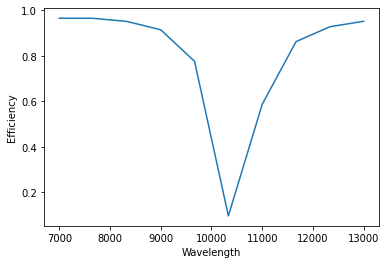

In [7]:

print(r)
import matplotlib.pyplot as plt
plt.plot(lambdas, np.abs(r))
plt.xlabel("Wavelength")
plt.ylabel("Efficiency")
plt.show()